# Кратко про предпосылки и результаты

    Игра с кодом с занятия меня притомила, потому всё переписано для проведения экспериментов и обработки результатов в более приемлемом формате

Но, увы и ах, получить лосс стабильный в районе 2.1 так и не получилось(понятно, что выбросы на бачах и 1.6 иногда давали, но ясно, что это просто разброс, но не тренд)

# Что попробовал и что получилось

## Пробовал менять буквально каждый аспект(см. код)

- Изменение lr(через scheduler) - плюс стабильность хода и небольшой прирост по результату   
- Увеличение глубины сети - делает сильно хуже (порог сдвигается к ~3)
- Использование ReLU - делает результаты хуже при любой модели
- Кол-во нейронов на уровнях - минорные сдвиги
- Увеличение корпуса слов - нет заметного вклада
- Изменение датасета (изменение окна) - минорный сдвиг (чуть хуже, когда мало(1,2) и совсем много(6))
- Нормализованы веса - ситуативно сглаживает старт, но на итоговый лосс не влияет само собой



Беда, короче говоря

In [19]:
import random
from collections import namedtuple
from pprint import pp

import pickle
from datetime import datetime
import itertools

import torch as tr
import torch.nn.functional as F

import matplotlib.pyplot as plt


In [20]:
class Dataset():
    def __init__(self, path, block_size, train_size):
        self.path_to_text = path
        self.block_size = block_size
        self.train_size = train_size
        self.words = None
        self.stoi = None
        self.itos = None
        self.dataset = None

        self._get_dataset()
        self._tokens_from_source()
        self._create_train_dev_test_split()

    def _get_dataset(self) -> None:
        self.words = open(self.path_to_text).read().splitlines()

    def _tokens_from_source(self):
        text = self.words
        chars = sorted(list(set("".join(text))))
        self.stoi = { ch : ix+1 for ix, ch in enumerate(chars) }
        self.stoi["."] = 0
        self.itos = { ix:ch for ch, ix in self.stoi.items() }

    def _create_dataset(self, text):
        stoi = self.stoi
        itos = self.itos
        block_size = self.block_size

        X, Y = [], []
        for word in text:
            context = [0 for _ in range(block_size)]
            for ch in word + ".":
                ix = stoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix]
        X = tr.tensor(X)
        Y = tr.tensor(Y)

        return X,Y

    def _create_train_dev_test_split(self):
        random.seed(42)
        random.shuffle(self.words)

        train_size = self.train_size
        val_size = (1 - train_size)/2

        n1 = int(train_size * len(self.words))
        n2 = int((train_size+val_size) * len(self.words))

        Xtr, Ytr = self._create_dataset(self.words[:n1])
        Xdev, Ydev = self._create_dataset(self.words[n1:n2])
        Xte, Yte = self._create_dataset(self.words[n2:])

        Train = namedtuple('Train', ['X', 'Y'])
        Dev = namedtuple('Dev', ['X', 'Y'])
        Test = namedtuple('Test', ['X', 'Y'])

        train_data = Train(Xtr, Ytr)
        dev_data = Dev(Xdev, Ydev)
        test_data = Test(Xte, Yte)

        self.dataset = {
            "train": train_data,
            "dev": dev_data,
            "test": test_data
        }


In [21]:
class Model():
    def __init__(self, dict_size, embed_size, hidden_layer_size, block_size):
        self.dict_size = dict_size
        self.embed_size = embed_size
        self.hidden_layer_size = hidden_layer_size
        self.block_size = block_size
        self.parameters = None

        self._init_parameters()
        self.__norm_weights()


    def get_meta(self):
        return { par_name: par.shape for par_name, par in self.parameters.items()}

    def zero_grad(self):
        for key, p in self.parameters.items():
            p.grad = None


    def update_weights(self, learning_rate):
        for key, p in self.parameters.items():
            p.data += - learning_rate * p.grad

    def train(self):
        for key, p in self.parameters.items():
            p.requires_grad = True

    def eval(self):
        for key, p in self.parameters.items():
            p.set_grad_enabled = False

    def __norm_weights(self):
        for key, p in self.parameters.items():
            tr.nn.init.normal_(p)

    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size))
        b_in = tr.randn(self.hidden_layer_size)

        W_last = tr.randn((self.hidden_layer_size, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,
            "W_in" : W_in,
            "b_in" : b_in,
            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]
        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]
        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = tr.tanh(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        logits = h @ W_last + b_last
        return logits

In [22]:
class ModelWithRelu(Model):
    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size))
        b_in = tr.randn(self.hidden_layer_size)

        W_last = tr.randn((self.hidden_layer_size, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,
            "W_in" : W_in,
            "b_in" : b_in,
            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]
        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]
        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = F.relu(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        probs = F.softmax(h @ W_last + b_last)
        return probs


In [23]:
class MLP3LayerWithTanh(Model):
    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size))
        b_in = tr.randn(self.hidden_layer_size)

        W_inner_1 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_1 = tr.randn(self.hidden_layer_size)

        W_inner_2 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_2 = tr.randn(self.hidden_layer_size)

        W_last = tr.randn((self.hidden_layer_size, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,

            "W_in" : W_in,
            "b_in" : b_in,

            "W_inner_1" : W_inner_1,
            "b_inner_1" : b_inner_1,

            "W_inner_2" : W_inner_2,
            "b_inner_2" : b_inner_2,

            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]

        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]

        W_inner_1 = self.parameters["W_inner_1"]
        b_inner_1 = self.parameters["b_inner_1"]

        W_inner_2 = self.parameters["W_inner_2"]
        b_inner_2 = self.parameters["b_inner_2"]

        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = F.tanh(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        h_1 = F.tanh(h @ W_inner_1 + b_inner_1 )
        h_2 = F.tanh(h_1 @ W_inner_2 + b_inner_2)
        logits = h_2 @ W_last + b_last
        return logits

In [24]:
class MLP3LayerWithRelu(Model):
    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size))
        b_in = tr.randn(self.hidden_layer_size)

        W_inner_1 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_1 = tr.randn(self.hidden_layer_size)

        W_inner_2 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_2 = tr.randn(self.hidden_layer_size)

        W_last = tr.randn((self.hidden_layer_size, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,

            "W_in" : W_in,
            "b_in" : b_in,

            "W_inner_1" : W_inner_1,
            "b_inner_1" : b_inner_1,

            "W_inner_2" : W_inner_2,
            "b_inner_2" : b_inner_2,

            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]

        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]

        W_inner_1 = self.parameters["W_inner_1"]
        b_inner_1 = self.parameters["b_inner_1"]

        W_inner_2 = self.parameters["W_inner_2"]
        b_inner_2 = self.parameters["b_inner_2"]

        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = F.relu(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        h_1 = F.relu(h @ W_inner_1 + b_inner_1 )
        h_2 = F.relu(h_1 @ W_inner_2 + b_inner_2)
        probs = F.softmax(h_2 @ W_last + b_last)
        return probs

In [25]:
class MLP3LayerWithReluTriangleHidden(Model):
    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size * 2))
        b_in = tr.randn(self.hidden_layer_size * 2)

        W_inner_1 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_1 = tr.randn(self.hidden_layer_size)

        W_inner_2 = tr.randn(self.hidden_layer_size, self.hidden_layer_size / 2)
        b_inner_2 = tr.randn(self.hidden_layer_size / 2)

        W_last = tr.randn((self.hidden_layer_size / 2, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,

            "W_in" : W_in,
            "b_in" : b_in,

            "W_inner_1" : W_inner_1,
            "b_inner_1" : b_inner_1,

            "W_inner_2" : W_inner_2,
            "b_inner_2" : b_inner_2,

            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]

        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]

        W_inner_1 = self.parameters["W_inner_1"]
        b_inner_1 = self.parameters["b_inner_1"]

        W_inner_2 = self.parameters["W_inner_2"]
        b_inner_2 = self.parameters["b_inner_2"]

        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = F.relu(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        h_1 = F.relu(h @ W_inner_1 + b_inner_1 )
        h_2 = F.relu(h_1 @ W_inner_2 + b_inner_2)
        probs = F.softmax(h_2 @ W_last + b_last)
        return probs

In [26]:
class MLP3LayerWithReluStarHidden(Model):
    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size))
        b_in = tr.randn(self.hidden_layer_size)

        W_inner_1 = tr.randn(self.hidden_layer_size, self.hidden_layer_size * 4)
        b_inner_1 = tr.randn(self.hidden_layer_size * 4)

        W_inner_2 = tr.randn(self.hidden_layer_size * 4, self.hidden_layer_size * 2)
        b_inner_2 = tr.randn(self.hidden_layer_size * 2)

        W_last = tr.randn((self.hidden_layer_size * 2, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,

            "W_in" : W_in,
            "b_in" : b_in,

            "W_inner_1" : W_inner_1,
            "b_inner_1" : b_inner_1,

            "W_inner_2" : W_inner_2,
            "b_inner_2" : b_inner_2,

            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]

        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]

        W_inner_1 = self.parameters["W_inner_1"]
        b_inner_1 = self.parameters["b_inner_1"]

        W_inner_2 = self.parameters["W_inner_2"]
        b_inner_2 = self.parameters["b_inner_2"]

        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = F.relu(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        h_1 = F.relu(h @ W_inner_1 + b_inner_1 )
        h_2 = F.relu(h_1 @ W_inner_2 + b_inner_2)
        probs = F.softmax(h_2 @ W_last + b_last)
        return probs


In [27]:
class MLP6LayerWithRelu(Model):
    def _init_parameters(self):
        C = tr.rand(self.dict_size, self.embed_size)

        W_in = tr.randn((self.block_size * self.embed_size, self.hidden_layer_size))
        b_in = tr.randn(self.hidden_layer_size)

        W_inner_1 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_1 = tr.randn(self.hidden_layer_size)

        W_inner_2 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_2 = tr.randn(self.hidden_layer_size)

        W_inner_3 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_3 = tr.randn(self.hidden_layer_size)

        W_inner_4 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_4 = tr.randn(self.hidden_layer_size)

        W_inner_5 = tr.randn(self.hidden_layer_size, self.hidden_layer_size)
        b_inner_5 = tr.randn(self.hidden_layer_size)

        W_last = tr.randn((self.hidden_layer_size, self.dict_size))
        b_last = tr.randn(self.dict_size)

        self.parameters = {
            "C"  : C,

            "W_in" : W_in,
            "b_in" : b_in,

            "W_inner_1" : W_inner_1,
            "b_inner_1" : b_inner_1,

            "W_inner_2" : W_inner_2,
            "b_inner_2" : b_inner_2,

            "W_inner_3" : W_inner_3,
            "b_inner_3" : b_inner_3,

            "W_inner_4" : W_inner_4,
            "b_inner_4" : b_inner_4,

            "W_inner_5" : W_inner_5,
            "b_inner_5" : b_inner_5,

            "W_last" : W_last,
            "b_last" : b_last
        }

    def forward(self, X):
        C = self.parameters["C"]

        W_in = self.parameters["W_in"]
        b_in = self.parameters["b_in"]

        W_inner_1 = self.parameters["W_inner_1"]
        b_inner_1 = self.parameters["b_inner_1"]

        W_inner_2 = self.parameters["W_inner_2"]
        b_inner_2 = self.parameters["b_inner_2"]

        W_inner_3 = self.parameters["W_inner_3"]
        b_inner_3 = self.parameters["b_inner_3"]

        W_inner_4 = self.parameters["W_inner_4"]
        b_inner_4 = self.parameters["b_inner_4"]

        W_inner_5 = self.parameters["W_inner_5"]
        b_inner_5 = self.parameters["b_inner_5"]

        W_last = self.parameters["W_last"]
        b_last = self.parameters["b_last"]

        emb = C[X]
        h = F.relu(emb.view(-1, self.block_size * self.embed_size) @ W_in + b_in)
        h_1 = F.relu(h @ W_inner_1 + b_inner_1 )
        h_2 = F.relu(h_1 @ W_inner_2 + b_inner_2)
        h_3 = F.relu(h_2 @ W_inner_3 + b_inner_3)
        h_4 = F.relu(h_3 @ W_inner_4 + b_inner_4)
        h_5 = F.relu(h_4 @ W_inner_5 + b_inner_5)
        probs = F.softmax(h_5 @ W_last + b_last)
        return probs


In [28]:
class Optimizer():
    def __init__(self, model_params, learning_rate, type):
        self.model_params = model_params
        self.learning_rate = learning_rate
        self.starting_learning_rate = learning_rate
        self.type = type

    def step(self):
        match self.type:
            case "none":
                pass

            case _ :
                self.type = "none"
                pass

    def get_meta(self):
        return {
            "learning_rate": self.starting_learning_rate,
            "type": self.type
        }

class Scheduler():
    def __init__(self, optimizer, type):
        self.optimizer = optimizer
        self.type = type

    def step(self, epoch, max_steps):
        match self.type:
            case "naive":
                self._naive(epoch, max_steps)
            case "cosine":
                self._naive_cosine(epoch, max_steps)
            case _ :
                self.type = "naive"
                self._naive(epoch, max_steps)

    def _naive_cosine(self, epoch, max_steps):
        min_lr = 1e-6
        self.optimizer.learning_rate = (
                min_lr + (1/2)*(self.optimizer.starting_learning_rate - min_lr)*
                (1 + tr.cos( (tr.tensor(epoch)/tr.tensor(max_steps))*tr.pi).item()))

    def _naive(self, epoch, max_steps):
        if epoch < max_steps * 0.5:
            self.optimizer.learning_rate -= self.optimizer.learning_rate * 0.000001

        if max_steps * 0.5 < epoch < max_steps * 0.75:
            self.optimizer.learning_rate -= self.optimizer.learning_rate * 0.00001

        if epoch > max_steps * 0.75:
            self.optimizer.learning_rate -= self.optimizer.learning_rate * 0.0001

    def get_meta(self):
        return {
            "opt": self.optimizer.get_meta(),
            "type": self.type
        }

In [29]:
class Trainer():
    def __init__(self, model,
                 train, dev, test,
                 batch_size,
                 max_steps,
                 optimizer,
                 scheduler
                 ):

        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.train = train
        self.dev = dev
        self.test = test

        self.batch_size = batch_size
        self.learning_rate = self.optimizer.learning_rate
        self.max_steps = max_steps

        self.train_lossi = []
        self.dev_lossi = []
        self.test_lossi = []

    def get_meta(self):
        loss_data = {
            "train": self.train_lossi,
            "dev": self.dev_lossi,
            "test": self.test_lossi
        }

        param = {
            "model_meta": self.model.get_meta(),
            "opt_meta": self.optimizer.get_meta(),
            "sch_meta": self.scheduler.get_meta(),

            "batch_size": self.batch_size,
            "max_steps": self.max_steps,
        }
        res = {
             "loss": loss_data,
             "parameters": param
        }
        return res

    def train_model(self):
        for epoch in range(self.max_steps):
            self.model.train()

            #forward
            ix = tr.randint(0, self.train.X.shape[0], (self.batch_size,))
            X = self.train.X[ix]
            Y_pred = self.model.forward(X)
            Y = self.train.Y[ix]
            loss = F.cross_entropy(Y_pred, Y)
            self.train_lossi.append(loss.item())

            #backward
            self.model.zero_grad()
            loss.backward()
            self.model.update_weights(self.learning_rate)

            self.scheduler.step(epoch, self.max_steps)
            self.model.eval()

            #validation
            ix = tr.randint(0, self.dev.X.shape[0], (self.batch_size,))
            X = self.dev.X[ix]
            Y_pred = self.model.forward(X)
            Y = self.dev.Y[ix]
            dev_loss = F.cross_entropy(Y_pred, Y)
            self.dev_lossi.append(dev_loss.item())

            if epoch % 1000 == 0:
                print("Epoch:", epoch)
                print(f"Train Loss: {loss.item()}")
                print(f"Validation Loss: {dev_loss.item()}")


    def test_model(self):
        self.model.eval()
        self.test_lossi = []

        for ind in range(0, self.test.X.shape[0] - self.batch_size, self.batch_size):
            l = ind
            r = ind + self.batch_size
            ix = tr.arange(l,r).reshape((self.batch_size,))
            X = self.test.X[ix]
            Y_pred = self.model.forward(X)
            Y = self.test.Y[ix]
            test_loss = F.cross_entropy(Y_pred, Y)
            self.test_lossi.append(test_loss.item())


In [30]:
class Experiment():
    def __init__(self,
                 Dataset=Dataset,
                 Model=Model,
                 Optimizer=Optimizer,
                 Scheduler=Scheduler,
                 Trainer=Trainer,

                 path="names.txt",
                 block_size=3,
                 train_size=0.8,

                 embed_size=3,
                 hidden_layer_size=50,
                 learning_rate=0.01,

                 opt_type="none",
                 sch_type="naive",

                 batch_size=32,
                 max_steps=100,
                 ):

        self.Dataset = Dataset
        self.Model = Model
        self.Optimizer = Optimizer
        self.Scheduler = Scheduler
        self.Trainer = Trainer


        names_dataset_params = {
            "path":path,
            "block_size" : block_size,
            "train_size" : train_size,
        }

        names_dataset = self.Dataset(**names_dataset_params)

        model_params = {
            "dict_size"  : len(names_dataset.stoi),
            "embed_size" : embed_size,
            "hidden_layer_size" : hidden_layer_size,
            "block_size" : names_dataset.block_size,
        }

        m = self.Model(**model_params)
        opt_params = {
            "model_params": m.parameters,
            "learning_rate": learning_rate,
            "type": opt_type,
        }
        opt = self.Optimizer(**opt_params)
        sch_params = {
            "optimizer":opt,
            "type":sch_type,
        }
        sch = self.Scheduler(**sch_params)

        train_params = {
            "model":m,
            "optimizer":opt,
            "scheduler":sch,
            "train": names_dataset.dataset["train"],
            "dev": names_dataset.dataset["dev"],
            "test": names_dataset.dataset["test"],
            "batch_size": batch_size,
            "max_steps": max_steps,
        }

        self.trainer = self.Trainer(**train_params)
        self.meta = {}

    def do(self):
        self.trainer.train_model()
        self.trainer.test_model()
        self.meta = self.get_meta()


    def get_meta(self):
        self.meta = self.trainer.get_meta()
        return self.meta

In [31]:
datasets = [Dataset]
models = [
    # Model,
    # ModelWithRelu,
    MLP3LayerWithTanh,
    # MLP3LayerWithRelu,
    # MLP3LayerWithReluTriangleHidden,
    # MLP3LayerWithReluStarHidden,
    # MLP6LayerWithRelu
]
optimizers = [Optimizer]
schedulers = [Scheduler]
trainers = [Trainer]

# path = "names.txt"
# path = "first-names.txt"
path = "/content/NAMES.txt"
block_sizes = [size for size in [
    # 2,
    3,
    # 4,5,6
]]

embed_sizes = [size for size in [
    # 2,
    10,
    # 20,50,100,200
]]
hidden_layer_sizes = [size for size in [
    # 50, 100, 150,
    200,
    # 250, 300
]]
learning_rates = [size for size in [
    # 1e-1,1e-2,1e-3,
    1e-4,
    # 1e-5,1e-6
]]

opt_types = ["none"]
sch_types = [
    # "naive",
    "cosine"
]

batch_sizes = [size for size in [
    # 8, 16,
    32,
    # 64, 128, 256, 512
]]
max_steps_sizes = [size for size in [
    # 50_000,
    # 100_000,
    200_000,
    # 500_000
]]

def generate_all_configs(
        datasets, models, optimizers, schedulers, trainers,block_sizes, embed_sizes, hidden_layer_sizes, learning_rates, opt_types, sch_types, batch_sizes, max_steps_sizes
):
    experiments_configs = []
    for dataset in datasets:
        for model in models:
            for optimizer in optimizers:
                for scheduler in schedulers:
                    for trainer in trainers:

                        for block_size in block_sizes:

                            for embed_size in embed_sizes:
                                for hidden_layer_size in hidden_layer_sizes:
                                    for learning_rate in learning_rates:

                                        for opt in opt_types:
                                            for sch in sch_types:

                                                for batch_size in batch_sizes:
                                                    for max_steps in max_steps_sizes:
                                                        config = {
                                                            "Dataset":dataset,
                                                            "Model":model,
                                                            "Optimizer":optimizer,
                                                            "Scheduler":scheduler,
                                                            "Trainer":trainer,

                                                            "path"               : path,
                                                            "block_size"         : block_size,
                                                            "train_size"         : 0.8,

                                                            "embed_size"         : embed_size,
                                                            "hidden_layer_size"  : hidden_layer_size,
                                                            "learning_rate"      : learning_rate,

                                                            "opt_type":          opt,
                                                            "sch_type":          sch,

                                                            "batch_size":        batch_size,
                                                            "max_steps" :        max_steps,
                                                        }

                                                        experiments_configs.append(config)

    return experiments_configs

experiments_config = generate_all_configs(
    datasets, models, optimizers, schedulers, trainers,block_sizes, embed_sizes, hidden_layer_sizes, learning_rates, opt_types, sch_types, batch_sizes, max_steps_sizes
)
len(experiments_config),experiments_config[0]

(1,
 {'Dataset': __main__.Dataset,
  'Model': __main__.MLP3LayerWithTanh,
  'Optimizer': __main__.Optimizer,
  'Scheduler': __main__.Scheduler,
  'Trainer': __main__.Trainer,
  'path': '/content/NAMES.txt',
  'block_size': 3,
  'train_size': 0.8,
  'embed_size': 10,
  'hidden_layer_size': 200,
  'learning_rate': 0.0001,
  'opt_type': 'none',
  'sch_type': 'cosine',
  'batch_size': 32,
  'max_steps': 200000})

In [32]:
save_model = False
for exp_ix, config in enumerate(experiments_config[:1]):
    experiment = Experiment(**config)
    experiment.do()
    exp_meta = experiment.get_meta()

    if save_model:
        with open(f"HW_2_additional/experiments/exp_{exp_ix}_{datetime.now()}.pickle", "wb") as outfile:
            pickle.dump(exp_meta, outfile, protocol=pickle.HIGHEST_PROTOCOL)


Epoch: 0
Train Loss: 30.296833038330078
Validation Loss: 32.619476318359375
Epoch: 1000
Train Loss: 25.606142044067383
Validation Loss: 22.54193115234375
Epoch: 2000
Train Loss: 20.43973731994629
Validation Loss: 23.107160568237305
Epoch: 3000
Train Loss: 26.578414916992188
Validation Loss: 20.425540924072266
Epoch: 4000
Train Loss: 18.086641311645508
Validation Loss: 20.546926498413086
Epoch: 5000
Train Loss: 19.916046142578125
Validation Loss: 19.06566047668457
Epoch: 6000
Train Loss: 17.81973648071289
Validation Loss: 16.367877960205078
Epoch: 7000
Train Loss: 15.252995491027832
Validation Loss: 17.587726593017578
Epoch: 8000
Train Loss: 14.985671043395996
Validation Loss: 16.651235580444336
Epoch: 9000
Train Loss: 13.842008590698242
Validation Loss: 18.394439697265625
Epoch: 10000
Train Loss: 13.935037612915039
Validation Loss: 16.356412887573242
Epoch: 11000
Train Loss: 14.659278869628906
Validation Loss: 16.401485443115234
Epoch: 12000
Train Loss: 12.99314022064209
Validation Los

Text(0.5, 1.0, 'test loss')

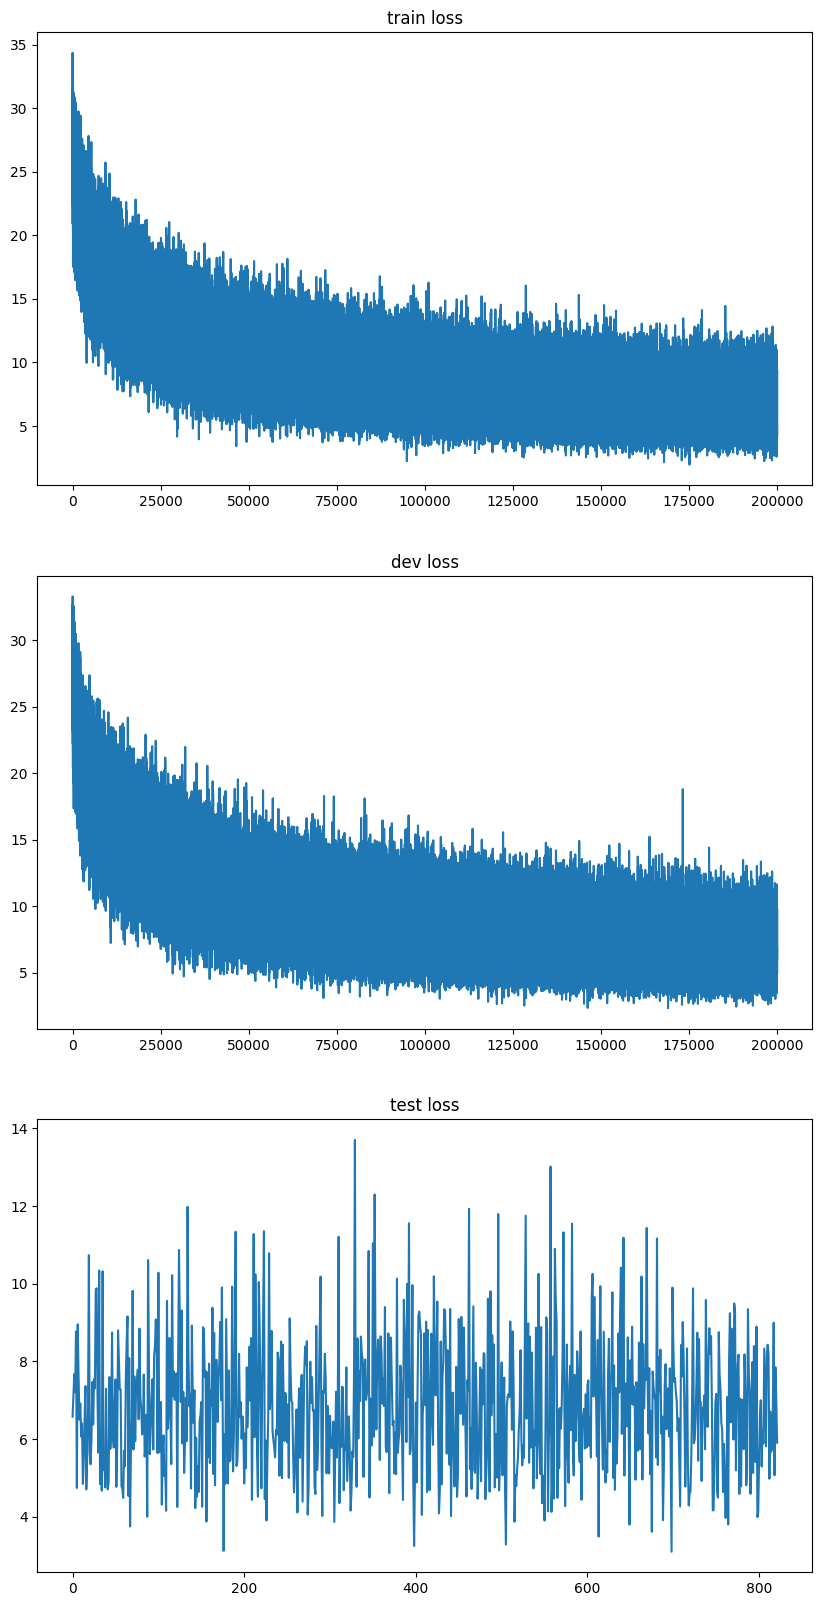

In [61]:
fig, ax = plt.subplots(3, figsize=(10,20))
ax[0].plot(exp_meta["loss"]["train"])
ax[0].set_title("train loss")
ax[1].plot(exp_meta["loss"]["dev"])
ax[1].set_title("dev loss")
ax[2].plot(exp_meta["loss"]["test"]);
ax[2].set_title("test loss")